In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import random
import shutil
from PIL import Image
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_predict
import math
from sklearn.model_selection import KFold

In [1]:
N1 = (69225 + 699531) % 2
N1

0

In [2]:
N1 = (69225 + 699531) % 2
N1

0

### Calculando a área da Celula

In [4]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, round(total_perimetro, 2)


### Calculando Compacidade

In [5]:
# perimetro^2 / 4 PI area
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = (perimetro**2) / (area * (4 * math.pi)) 
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [6]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    # (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    elipse = cv2.fitEllipse(maior_contorno)
    eixo_maior = max(elipse[1])
    eixo_menor = min(elipse[1])
    # Restante do seu código
  else:
    return 0


  # Calcular excentricidade
  # 1-menor^2 / 1-maior^2
  
  excentricidade = 1 - ((eixo_menor ** 2) / (eixo_maior ** 2))
  
  # if(eixo_maior != 0 and eixo_menor != 0):
  #   value_mid = round((eixo_menor / eixo_maior)**2, 2)
  # else:
  #   return 0
  
  # excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

### Gerar CSV

In [7]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "../data/segmentation_dataset_binario/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        
        csv['area'].append(round(area,2))
        csv['label'].append(nomeClasse)
        csv['compacidade'].append(calcularCompacidade(imagem))
        csv['excentricidade'].append(calcularExcentricidades(imagem))
          
  
       
df = pd.DataFrame(csv)
df.to_csv('../csv_pt2_binario.csv', index=False)       


In [12]:
df = pd.read_csv("../csv_pt2_binario.csv")

### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

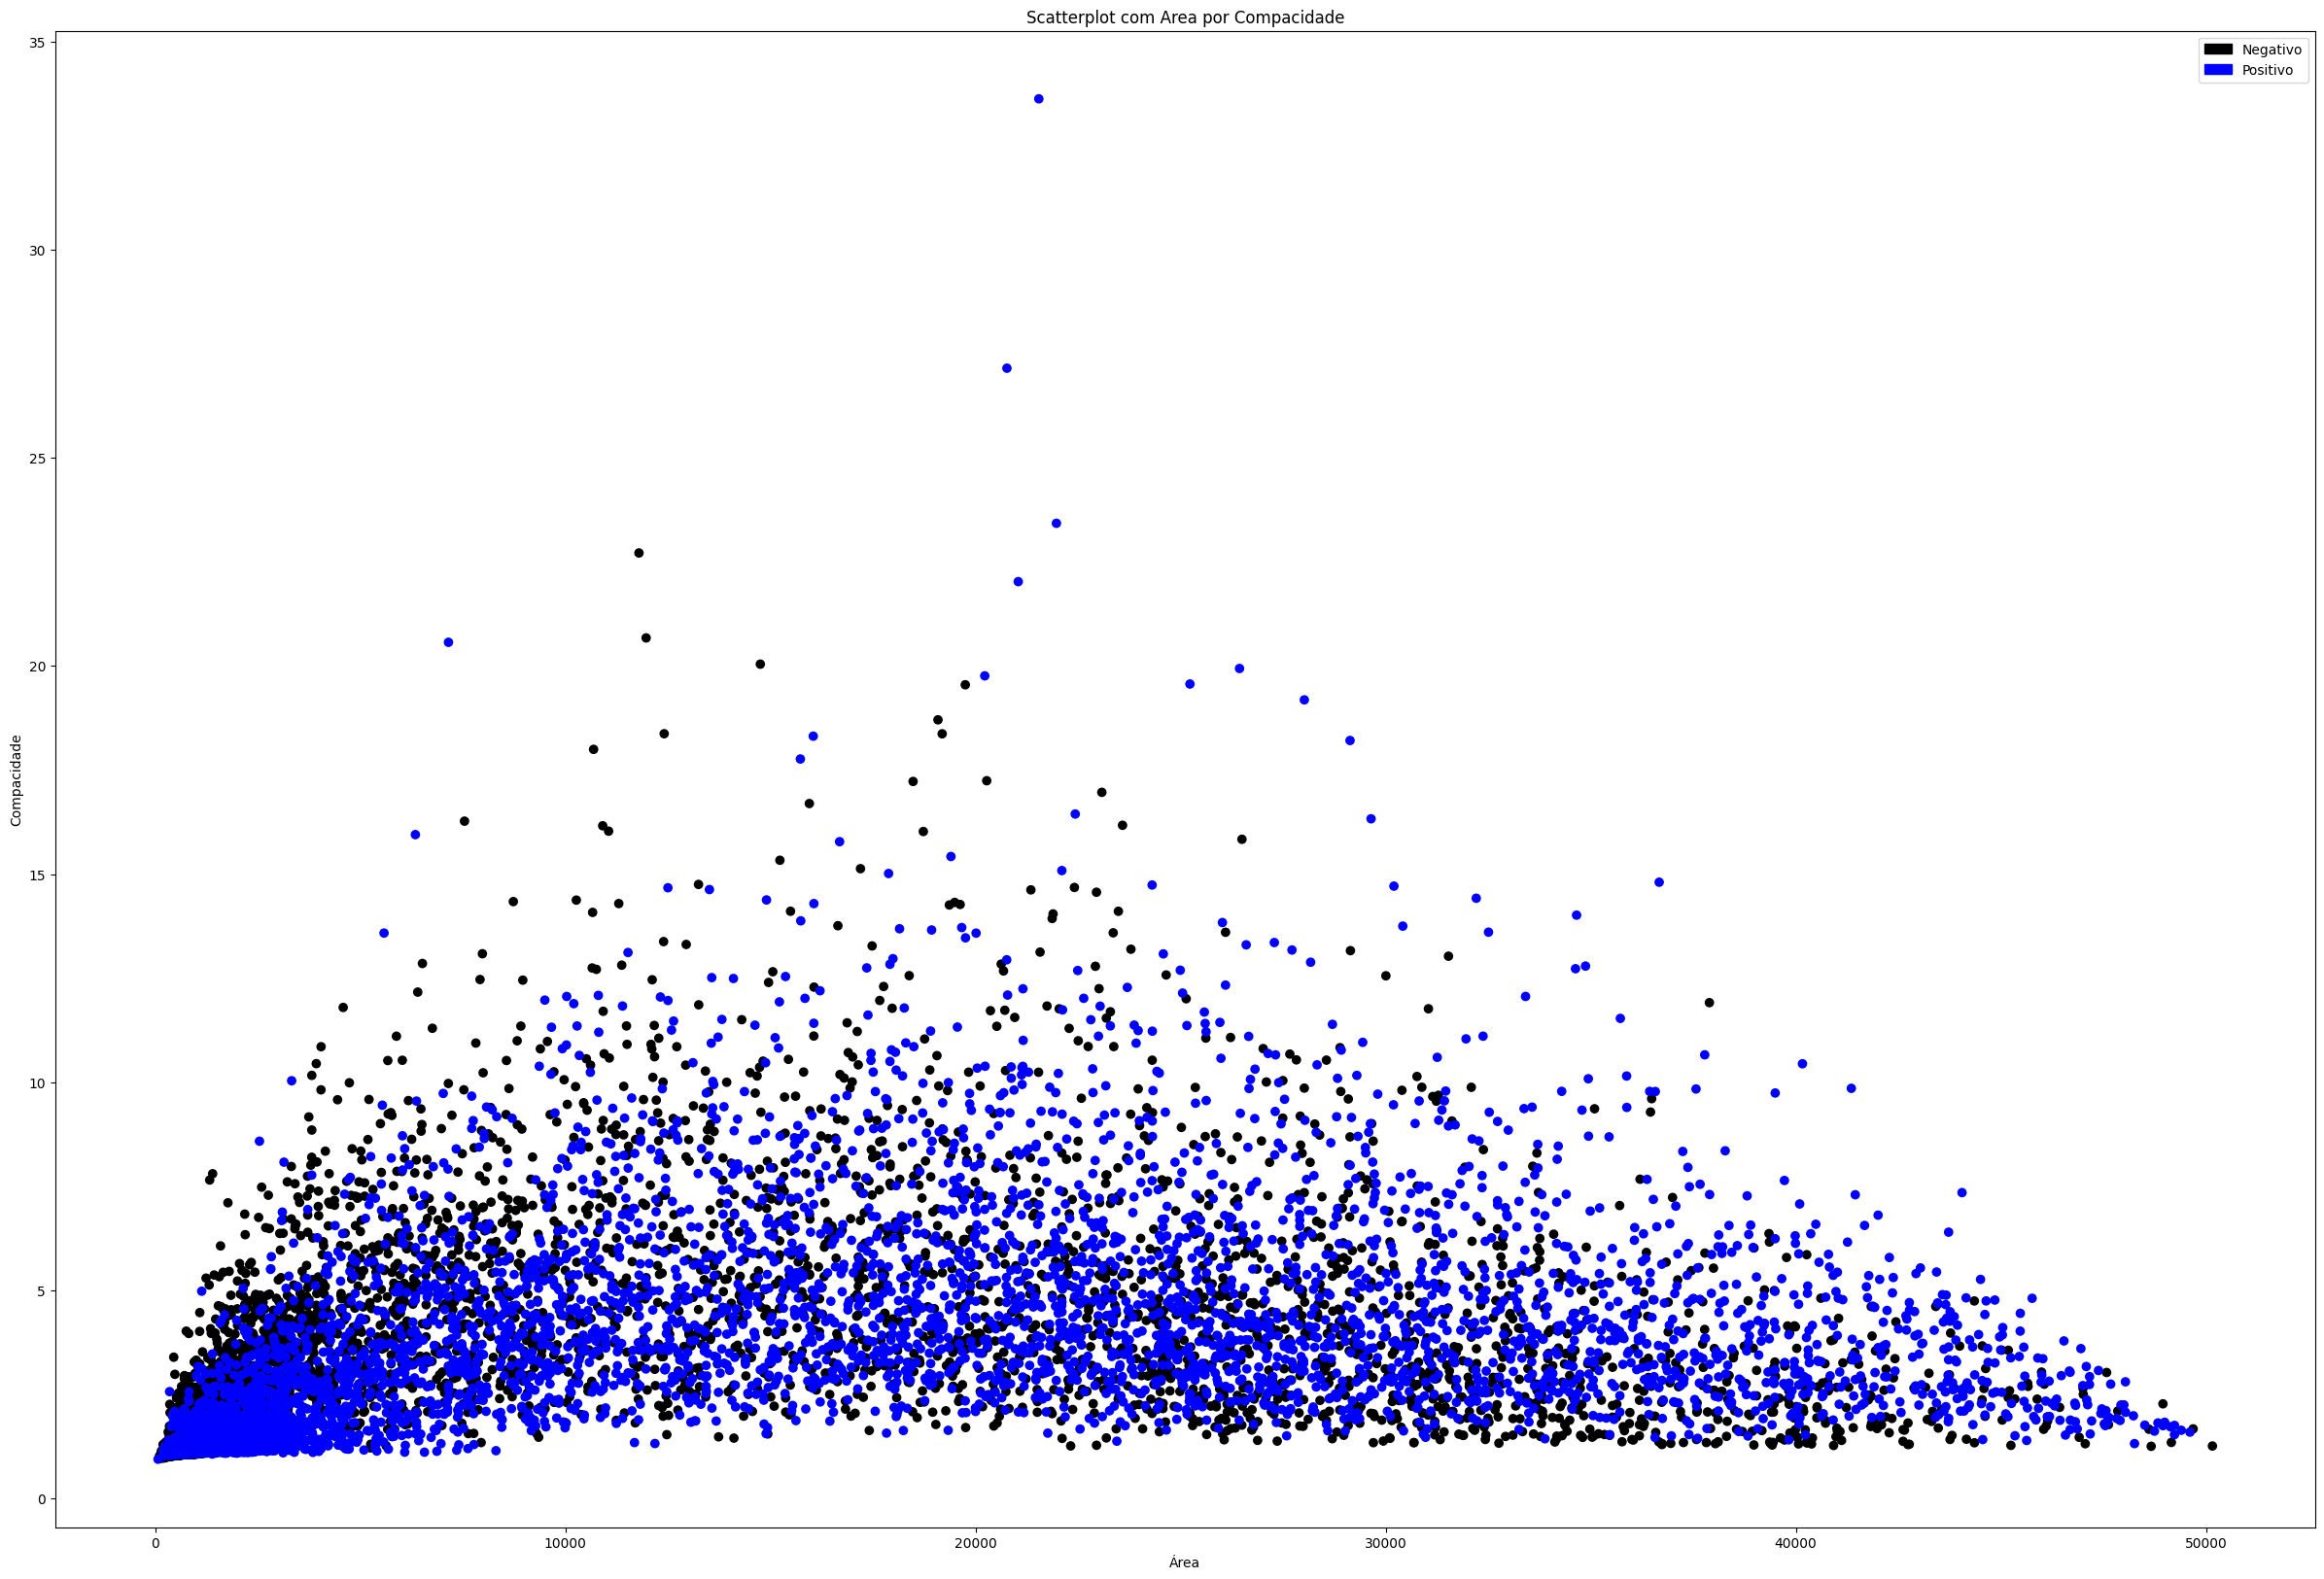

In [8]:
cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

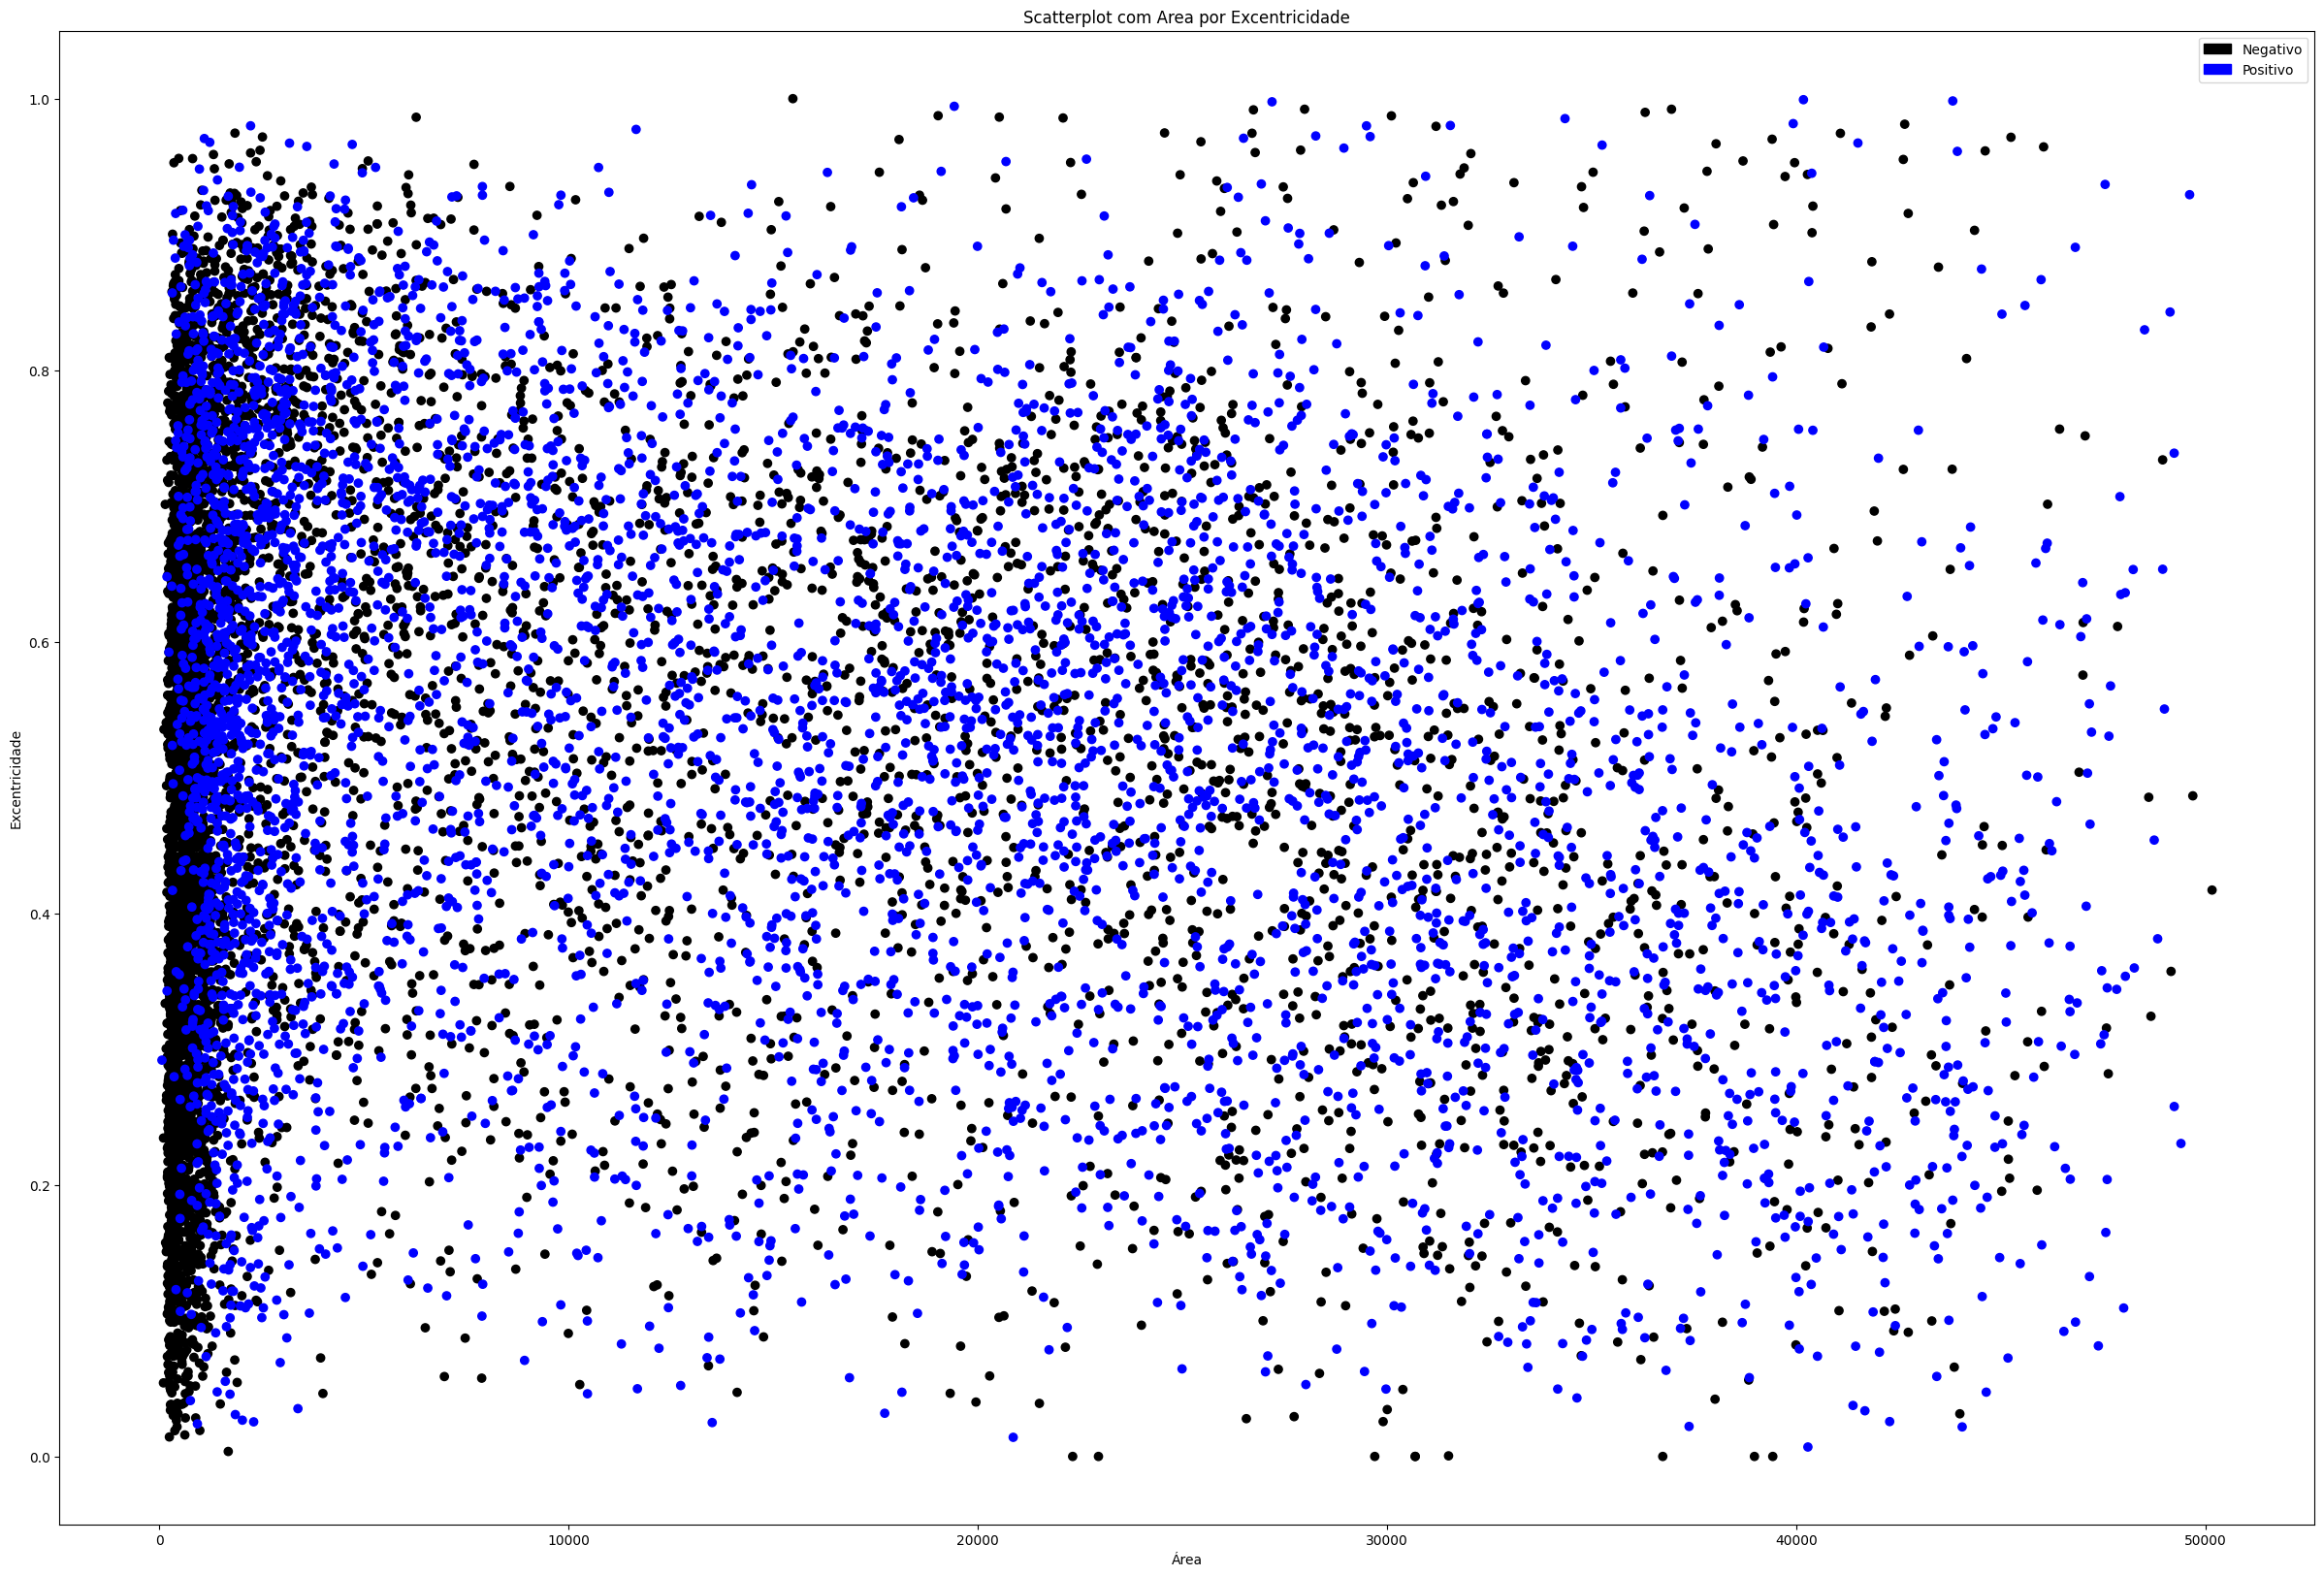

In [9]:
df_filter = df

cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df_filter['Cor'] = df_filter['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df_filter['area'], df_filter['excentricidade'], c=df_filter['Cor'], label=df_filter['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Excentricidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
# plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

### Dividindo o dataset em treino e teste

In [12]:
def obter_nomes_pastas(diretorio):
    nomes_pastas = []
    for nome in os.listdir(diretorio):
        if os.path.isdir(os.path.join(diretorio, nome)):
            nomes_pastas.append(nome)
    return nomes_pastas
  
  
# Exemplo de uso
diretorioPC = "D:\AREA_DE_TRABALHO\Faculdade_6_Periodo\pai\pai-papanicolau\src\AI\data/"

# diretorio = cwd + "/data/segmentation_dataset_binario/"
diretorio = f"{diretorioPC}segmentation_dataset_binario/"
pastas = obter_nomes_pastas(diretorio)

diretorio_origem = diretorio
diretorio_destino = f"{diretorioPC}segmentation_dataset_binario_treino/"

percent = 0.8

for each in pastas:

    # Diretório contendo todas as imagens
    diretorio_imagens = diretorio_origem + f'/{each}/'

    # Diretório para salvar as imagens de treinamento
    diretorio_treinamento = diretorio_destino + f'/train/{each}/'

    # Diretório para salvar as imagens de teste
    diretorio_teste = diretorio_destino + f'/test/{each}/'

    # Lista todas as imagens no diretório
    imagens = os.listdir(diretorio_imagens)

    # Embaralha a lista de imagens
    random.shuffle(imagens)

    # Calcula o índice para dividir as imagens
    indice_divisao = int(percent * len(imagens))

    # Separa as imagens em treinamento e teste
    imagens_treinamento = imagens[:indice_divisao]
    imagens_teste = imagens[indice_divisao:]

    if not (os.path.exists(diretorio_teste)):
        os.makedirs(diretorio_teste)

    if not (os.path.exists(diretorio_treinamento)):
        os.makedirs(diretorio_treinamento)

    # Move as imagens para os diretórios correspondentes
    for imagem in imagens_treinamento:
        shutil.copy(os.path.join(diretorio_imagens, imagem),
                    diretorio_treinamento)

    for imagem in imagens_teste:
        shutil.copy(os.path.join(diretorio_imagens, imagem), diretorio_teste)



### Calculando Mahalanobis 6 Classes

In [19]:
df = pd.read_csv('../csv_pt2_binario.csv')
df

,id_cel,label,area,compacidade,excentricidade
0,1000,Negativo,15359,8.7726,0.486872
1,1001,Negativo,33586,7.9791,0.227140
2,1002,Negativo,4063,4.4228,0.850684
3,1003,Negativo,261,1.0067,0.114213
4,10034,Negativo,858,1.0648,0.188955
...,...,...,...,...,...
11529,9995,Positivo,7146,4.8466,0.796064
11530,9996,Positivo,13427,5.4972,0.161394
11531,9997,Positivo,14443,3.7259,0.364736
11532,9998,Positivo,1344,1.8102,0.723415


In [14]:
# Dividindo em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [15]:
train_df

,id_cel,label,area,compacidade,excentricidade
916,11051,Negativo,875,1.2816,0.751900
5969,7194,Negativo,1413,2.2334,0.693502
10821,9167,Positivo,12686,5.9797,0.517154
1616,1552,Negativo,725,1.0972,0.243538
8574,4562,Positivo,7415,3.1648,0.869278
...,...,...,...,...,...
11284,9651,Positivo,15882,3.1460,0.504275
5191,6454,Negativo,223,1.0421,0.254745
5390,6653,Negativo,232,1.0327,0.126677
860,10999,Negativo,842,1.1976,0.581101


In [16]:
def calcular_estatisticas_por_classe(df):
    estatisticas_por_classe = {}
    for classe in df['label'].unique():
        classe_df = df[df['label'] == classe]
        
        # Converta as colunas para números
        numeric_columns = ['area', 'compacidade', 'excentricidade']
        for col in numeric_columns:
            classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
        
        estatisticas_por_classe[classe] = {
            'media': np.mean(classe_df[numeric_columns], axis=0),
            'covariancia': np.cov(classe_df[numeric_columns], rowvar=False)
        }
    return estatisticas_por_classe
# Calcule as estatísticas para o conjunto de treinamento
estatisticas_treinamento = calcular_estatisticas_por_classe(train_df)


for each in estatisticas_treinamento.items():
  print(each)

('Negativo', {'media': area              8500.480273
compacidade          2.886380
excentricidade       0.507989
dtype: float64, 'covariancia': array([[1.34345874e+08, 1.21042451e+04, 2.13625914e+01],
       [1.21042451e+04, 6.28035715e+00, 5.32817120e-02],
       [2.13625914e+01, 5.32817120e-02, 4.67659204e-02]])})
('Positivo', {'media': area              16399.726269
compacidade           3.963699
excentricidade        0.524287
dtype: float64, 'covariancia': array([[ 1.78227188e+08,  1.10814636e+04, -7.29440529e+02],
       [ 1.10814636e+04,  7.23704231e+00, -8.28460599e-02],
       [-7.29440529e+02, -8.28460599e-02,  4.30915204e-02]])})


C:\Users\Viny\AppData\Local\Temp\ipykernel_56164\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_56164\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')


Acurácia: 0.6272214997832684
Matriz de Confusão:
[[860 495]
 [365 587]]


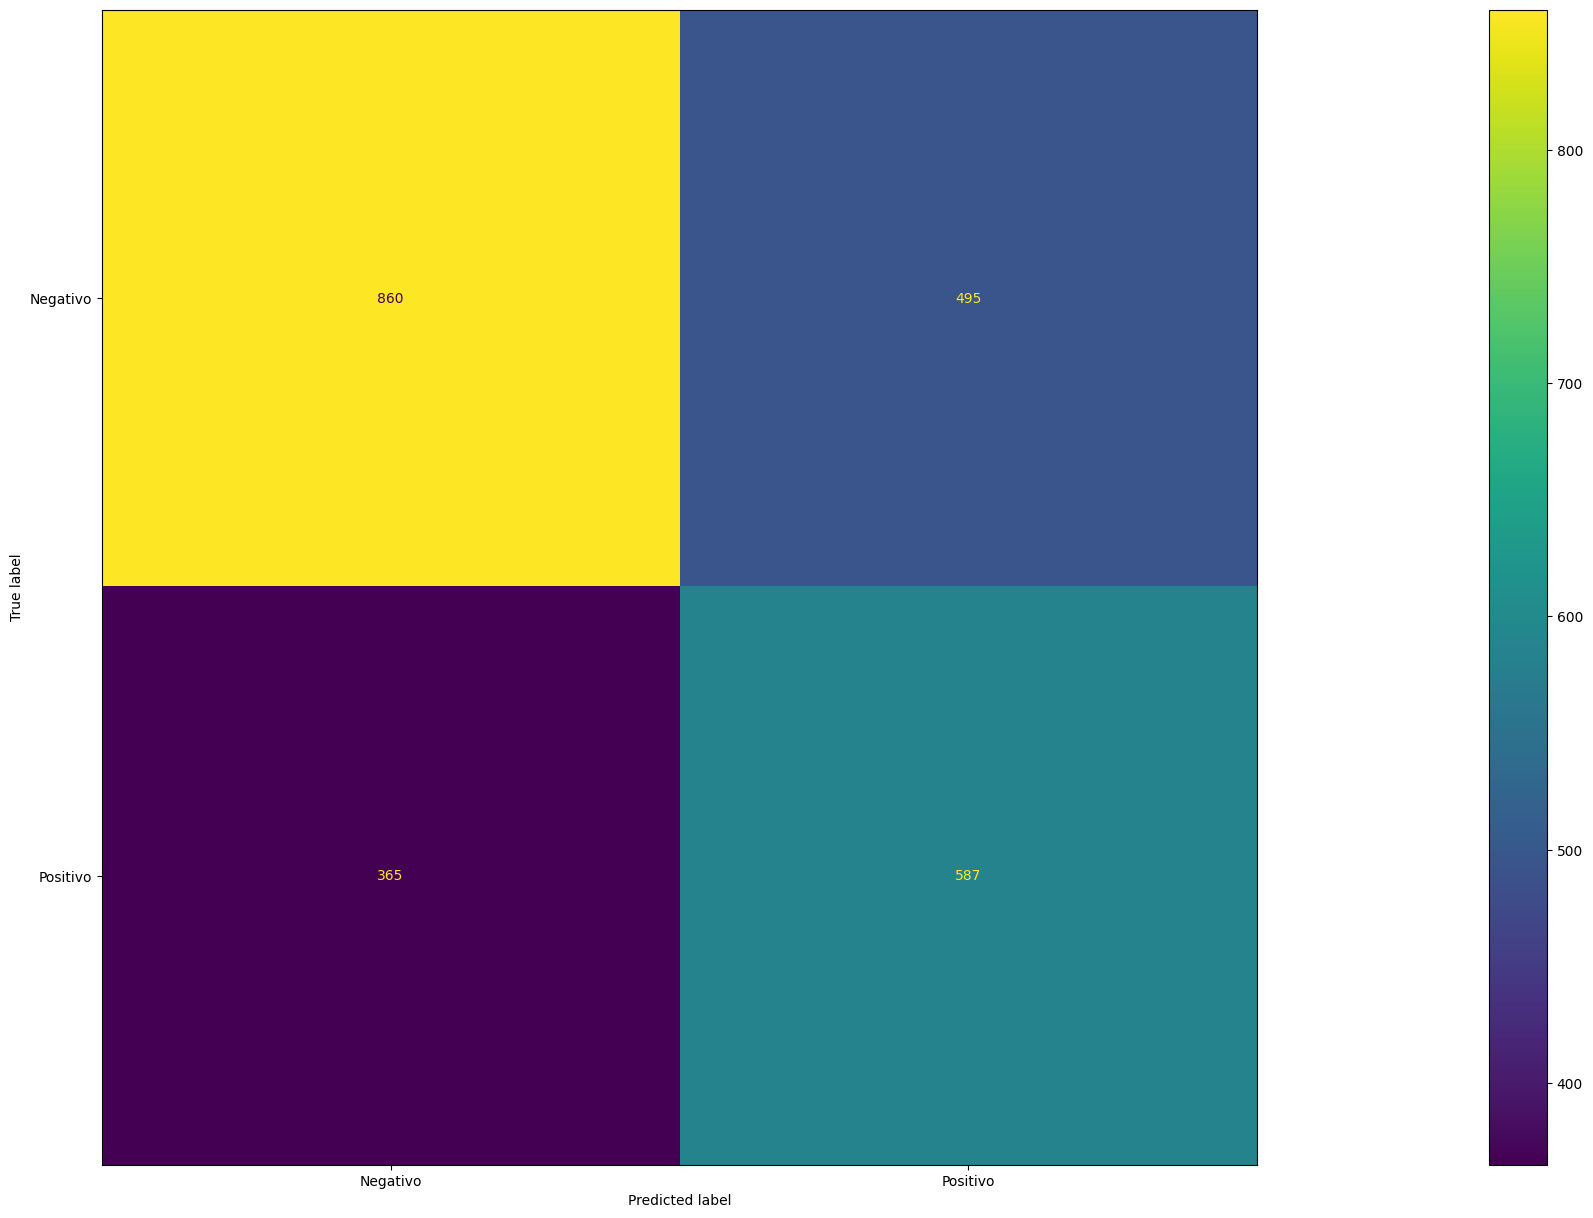

In [18]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


# Acurácia
acuracia = accuracy_score(test_df['label'], test_df['predicao_mahalanobis'])
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])

y_true = test_df['label']
y_pred = test_df['predicao_mahalanobis']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)


labels = ["Negativo", "Positivo"]
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)

### Cross Validation Mahanalobis

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import mahalanobis
class MahalanobisClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estatisticas_por_classe):
        self.estatisticas_por_classe = estatisticas_por_classe

    def fit(self, X, y=None):
        return self  # Não é necessário treinamento separado

    def predict(self, X):
        y_pred = []

        for _, amostra in X.iterrows():
            distancias = {}

            for classe, estatisticas in self.estatisticas_por_classe.items():
                distancias[classe] = mahalanobis(
                    amostra[['area', 'compacidade', 'excentricidade']],
                    estatisticas['media'],
                    np.linalg.inv(estatisticas['covariancia'])
                )

            predicao = min(distancias, key=distancias.get)
            y_pred.append(predicao)

        return y_pred

Acurácia: 0.6272214997832684
Matriz de Confusão:
[[860 495]
 [365 587]]


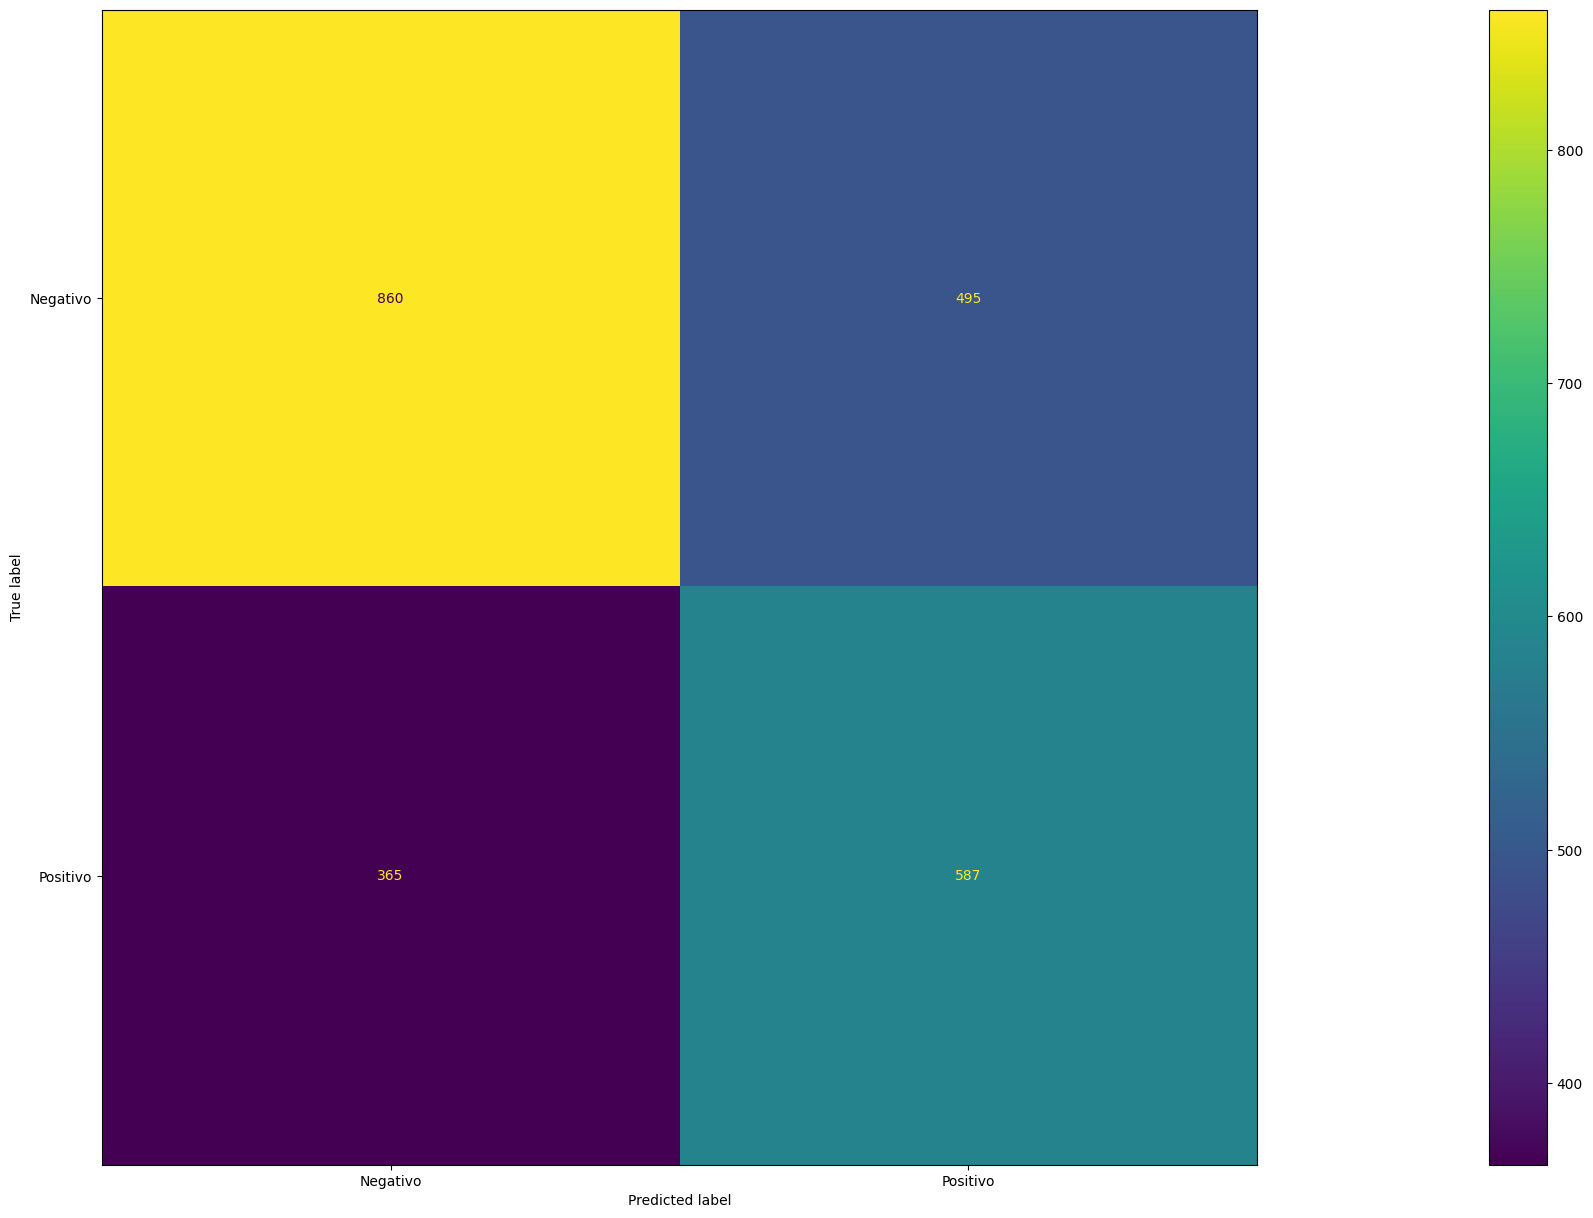

In [21]:
mahalanobis_estimator = MahalanobisClassifier(estatisticas_por_classe=estatisticas_treinamento)


y_pred = cross_val_predict(mahalanobis_estimator, 
                            X=test_df[['area', 'compacidade', 'excentricidade']],  # Conjunto de teste
                            y=test_df['label'], 
                            cv=5)  # Número de folds para a validação cruzada

# Acurácia
acuracia = accuracy_score(test_df['label'], y_pred=y_pred)
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
y_true = test_df['label']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)


labels = ["Negativo", "Positivo"]
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)
